# Import libraries, read data, text normalization process

In [1]:
# Import libraries
import re
import string
import numpy as np
import pandas as pd
from pprint import pprint
import math
from textblob import TextBlob
#from better_profanity import profanity

# Nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# borrowed from stackoverflow https://stackoverflow.com/a/49146722
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

def remove_unwanted(document):

    # remove URLS 
    document = re.sub(r'http\S+', ' ', document)
    # remove emoji's
    document = remove_emoji(document)
    # remove punctuation
    document = re.sub("[^0-9A-Za-z ]", "" , document)
    # remove double spaces
    document = document.replace('  ',"")
    
    return document.strip()

In [4]:
def lemmatize_text(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
    words_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]   
    lemma_list = [wd.lemmatize(tag) for wd, tag in words_tags]
    
    lemmatized_sentence = " ".join(lemma_list)
    return lemmatized_sentence

In [5]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [6]:
data = pd.read_csv("Harvey_stressor.csv")

exclusive_emotion = ["approval","desire","admiration","love","gratitude","excitement","optimism","joy","amusement","neutral"]
extracted_data = data.loc[~data["Emotion"].isin(exclusive_emotion)].reset_index(drop=True)

extracted_data['Tweet']=extracted_data['Tweet'].astype(str)

text_corpus = extracted_data

In [7]:
text_corpus

,level_0,index,Unnamed: 0,ID,Likes,Replies,Retweets,Time,Tweet,Emotion
0,0,1,1.0,9.010000e+17,0.0,0.0,0.0,2017-08-25 14:44:00,As Hurricane Harvey be fast approach now be th...,caring
1,1,6,6.0,9.010000e+17,0.0,0.0,0.0,2017-08-25 14:44:00,If youre able give blood at RedCrossDonate blo...,disapproval
2,2,9,9.0,9.010000e+17,4.0,0.0,6.0,2017-08-25 14:44:00,Lifethreatening Hurricane Harvey head toward T...,curiosity
3,3,10,10.0,9.010000e+17,0.0,0.0,0.0,2017-08-25 14:44:00,Daddy please get out of the way of HurricaneHa...,caring
4,4,11,11.0,9.010000e+17,0.0,0.0,0.0,2017-08-25 14:44:00,Everyone please pray for Texas Hurricane Harve...,caring
...,...,...,...,...,...,...,...,...,...,...
98224,98224,399390,224342.0,9.030000e+17,0.0,0.0,0.0,2017-08-29 13:56:00,How You Can Help the Victims of Hurricane Harvey,curiosity
98225,98225,399394,224346.0,9.030000e+17,0.0,0.0,0.0,2017-08-29 13:56:00,Hurricane Harvey How to help in time of need,curiosity
98226,98226,399398,224350.0,9.030000e+17,0.0,0.0,0.0,2017-08-29 13:56:00,To everyone affect by Hurricane Harvey send yo...,caring
98227,98227,399404,224356.0,9.030000e+17,0.0,0.0,0.0,2017-08-29 13:57:00,Our thought be with our neighbor in the South ...,caring


In [8]:
extracted_data['Tweet']= extracted_data['Tweet'].astype(str)

    
text_corpus1 = extracted_data["Tweet"].astype(str)

len(text_corpus1)

98229

In [9]:
text_corpus1

0        As Hurricane Harvey be fast approach now be th...
1        If youre able give blood at RedCrossDonate blo...
2        Lifethreatening Hurricane Harvey head toward T...
3        Daddy please get out of the way of HurricaneHa...
4        Everyone please pray for Texas Hurricane Harve...
                               ...                        
98224     How You Can Help the Victims of Hurricane Harvey
98225         Hurricane Harvey How to help in time of need
98226    To everyone affect by Hurricane Harvey send yo...
98227    Our thought be with our neighbor in the South ...
98228    Marylanders head to Texas to assist with Hurri...
Name: Tweet, Length: 98229, dtype: object

### This section is for expansion purpose

In [10]:
# climate_data = []
# vocab = ["climate","warming","global","change","carbon","pollution","greenhouse","energy","fossil","fuel","hoax"]
# words_re = re.compile("|".join(vocab))

# for tweet in text_corpus:
#     if words_re.search(tweet):
#         climate_data.append(tweet)

# len(climate_data)

In [11]:
new_corpus = []

for text in text_corpus1:

    clean_text = remove_unwanted(str(text))
    clean_text = ' '.join([w for w in clean_text.split() if len(w)>1])
    clean_text = lemmatize_text(clean_text)
    new_corpus.append(clean_text)

new_corpus = np.array(new_corpus)

In [12]:
new_corpus

array(['As Hurricane Harvey be fast approach now be the time to do what you can to prepare your property to minimize',
       'If youre able give blood at RedCrossDonate blood time money skillsHurricane Harvey be bad oneunite help serve',
       'Lifethreatening Hurricane Harvey head toward Texas coastx000D pictwittercom8R18AJKuYf',
       ...,
       'To everyone affect by Hurricane Harvey send you all my best wish and hope',
       'Our thought be with our neighbor in the South who have be impact by Hurricane Harvey If you be interest in help donate',
       'Marylanders head to Texas to assist with Hurricane Harvey reliefpictwittercomVBxzphLqAg'],
      dtype='<U200')

In [13]:
#clean_tweet_data = np.array(new_corpus) 
#extracted_data["Tweet"] = clean_tweet_data
#extracted_data.to_csv('Harvey_stressor.csv',index=False)

In [14]:
stop_words = stopwords.words('english')
extended_words = ["hurricaneharvey","hurricane","harvey","texas","austin","galveston","storm","winds","houston","david","usa","twitter","donald",
                  "trump","trumps","san","hey","houstons","southeast","tomorrow","else","potus"," harveys","texans","via","wind","tx","harvey2017",
                  "corpus","christi","harveys","mph","category","cat","gulf","coast","hurricanharvey","category4","x000dhurricaneharvey","x000dhurricanharvey",
                  "ha","wa","130","harveyx000d","hurricaineharvey","x000d","atonio","harveystay","mexico","2017","louisiana","corpuschristi"]
stop_words.extend(extended_words)

In [15]:
tokenizer = RegexpTokenizer(r'\w+')

tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=stop_words,
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize,
                        max_features=500,
                        encoding='utf-8')

train_data = tfidf.fit_transform(new_corpus)


C:\Users\south\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [16]:
indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names_out()
top_n = 500
top_features = [features[i] for i in indices[:top_n]]
print (top_features)

['word', '10', 'snapchat', 'havent', 'stick', 'newshurricane', 'ur', 'service', 'include', 'strength', 'food', 'administration', 'alligator', 'ban', 'literally', 'horrible', 'government', 'inch', 'pls', 'prayersfortexas', 'barrel', 'potential', 'drown', 'nature', 'probably', 'ago', 'absolutely', 'important', 'seem', 'able', 'sustain', 'play', 'assist', 'fly', 'saturday', 'problem', '130mph', 'others', 'heed', 'neighbor', 'smart', 'rn', 'southern', 'world', 'station', 'terrible', 'massive', 'car', 'staysafe', 'result', 'moment', 'surround', 'whole', 'focus', 'build', 'beware', 'central', 'situation', 'dry', 'toll', 'poor', 'travel', 'hasnt', 'person', 'modern', 'vote', 'money', 'read', 'question', 'protection', 'business', 'reporter', 'rescue', 'risk', 'filter', 'open', 'must', 'listen', 'port', 'responder', 'wishing', 'effort', 'drive', 'hurt', 'weatherchannel', 'huge', 'brother', 'end', 'theyre', 'heavy', 'sister', 'set', 'monster', 'tropical', 'harm', 'predict', 'surprise', 'jesus', 

# Create WordCloud

In [17]:
#convert object to string
import string
string_terms=str(top_features)
string_terms = ' '.join(top_features).lower()
REPLACE_APS = re.compile(r"[\']")
string_terms = REPLACE_APS .sub("", string_terms)
print(string_terms)
print(type(string_terms))

word 10 snapchat havent stick newshurricane ur service include strength food administration alligator ban literally horrible government inch pls prayersfortexas barrel potential drown nature probably ago absolutely important seem able sustain play assist fly saturday problem 130mph others heed neighbor smart rn southern world station terrible massive car staysafe result moment surround whole focus build beware central situation dry toll poor travel hasnt person modern vote money read question protection business reporter rescue risk filter open must listen port responder wishing effort drive hurt weatherchannel huge brother end theyre heavy sister set monster tropical harm predict surprise jesus pay experience image story community rainfall steve survive attention sandy americans outside forecast side issue lets enough forget local buy worried aid dear american wan dallas stand watching alerthurricane medium white pretty wall america tip fear dog county town affected official photos ha

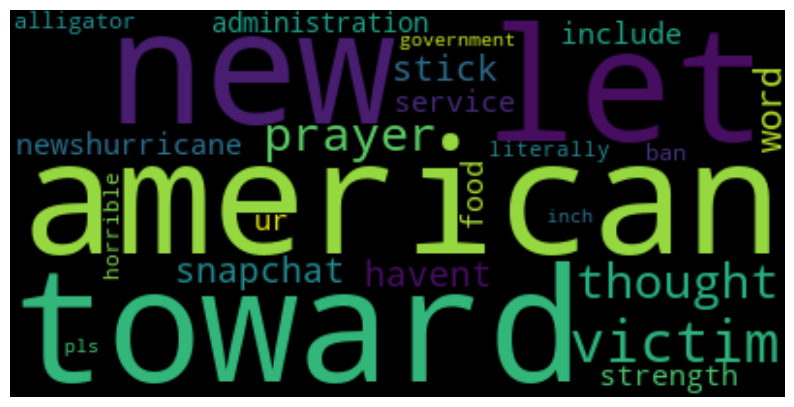

In [18]:
#for plotting images & adjusting colors
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import wordcloud
from wordcloud import WordCloud,STOPWORDS

## CREATE THE WORDCLOUD
# setting stopwords
stop_words = set(STOPWORDS)

# generating a wordcloud
wordcloud = WordCloud(stopwords=stop_words, max_font_size=150, 
                      min_font_size=9, collocations=True).generate(string_terms)

# show
plt.figure(figsize=[10,10])
plt.axis("off")

# store to file
plt.imshow(wordcloud, interpolation='bilinear')
#plt.savefig("Downloads/Harvey.png", format="png")